<a href="https://colab.research.google.com/github/kmunve/APS/blob/master/Predict_aval_problem_combined.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting tomorrow's avalanche problem

We use features from the last 3 days avalanche warnings to predict the main avalanche problem for the coming day.
An avalanche problem describes why an avalanche danger exists and how severe it is.

An avalanche problem contains a cause, a distribution, a potential avalanche size and a sensitivity of triggering. E.g. 



*   Cause: Wind slabs
*   Distribution: Widespread
*   Size: Large
*   Sensitivity: Easy to trigger

This is encoded as a 4-digit number where each digit encodes one of the four parameters, e.g. 5332.


We use differnet decision tree approaches to predict these four elements.

## Imports

In [184]:
import pandas as pd
import numpy as np
import json
import sklearn
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

print('Pandas:\t', pd.__version__)
print('Numpy:\t', np.__version__)
print('Scikit Learn:\t', sklearn.__version__)
print('Matplotlib:\t', matplotlib.__version__)

Pandas:	 0.24.2
Numpy:	 1.16.5
Scikit Learn:	 0.21.3
Matplotlib:	 3.0.3


## Data

In [185]:
# define the decoder function for the 4-digit avalanche problem target

!curl https://raw.githubusercontent.com/kmunve/APS/master/aps/config/snoskred_keys.json > snoskred_keys.json

def print_aval_problem_combined(aval_combined_int):
    aval_combined_str = str(aval_combined_int)
    with open('snoskred_keys.json') as jdata:
        snoskred_keys = json.load(jdata)
    type_ = snoskred_keys["Class_AvalancheProblemTypeName"][aval_combined_str[0]]
    dist_ = snoskred_keys["Class_AvalDistributionName"][aval_combined_str[1]]
    sens_ = snoskred_keys["Class_AvalSensitivityId"][aval_combined_str[2]]
    size_ = snoskred_keys["DestructiveSizeId"][aval_combined_str[3]]
    
    return f"{type_} : {dist_} : {sens_} : {size_}"

print(print_aval_problem_combined(6231))

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4083  100  4083    0     0  22938      0 --:--:-- --:--:-- --:--:-- 22938
Wind slab : Specific : Reactive : Small


In [186]:
# get the data

### Dataset with previous forecasts and observations
v_df = pd.read_csv('https://raw.githubusercontent.com/hvtola/HTLA/master/varsom_ml_preproc_htla2.csv', index_col=0) # --- Added even more data from RegObs
# v_df = pd.read_csv('https://raw.githubusercontent.com/hvtola/HTLA/master/varsom_ml_preproc_htla.csv', index_col=0)

### Dataset with previous forecasts only
# v_df = pd.read_csv('https://raw.githubusercontent.com/kmunve/APS/master/aps/notebooks/ml_varsom/varsom_ml_preproc_3y.csv', index_col=0).drop_duplicates() # for some reason we got all rows twice in that file :-(


# v_df[['date', 'region_id', 'region_group_id', 'danger_level', 'avalanche_problem_1_cause_id']].head(791*4+10)
# v_df['region_id'].value_counts()
v_df['region_id'].value_counts()

3022    792
3015    792
3024    792
3011    792
3027    792
3010    792
3013    792
3029    792
3012    792
3028    792
3031    792
3023    792
3014    792
3017    792
3016    792
3032    792
3003    792
3035    792
3034    792
3007    792
3009    792
Name: region_id, dtype: int64

In [0]:
# v_df['date'].value_counts()

In [188]:
# keep only numeric columns
from pandas.api.types import is_numeric_dtype
num_cols = [var for var in v_df.columns.values if is_numeric_dtype(v_df[var])] 
    
print(len(num_cols))
num_cols

171


['avalanche_problem_1_cause_id',
 'avalanche_problem_1_destructive_size_ext_id',
 'avalanche_problem_1_distribution_id',
 'avalanche_problem_1_exposed_height_1',
 'avalanche_problem_1_exposed_height_2',
 'avalanche_problem_1_ext_id',
 'avalanche_problem_1_probability_id',
 'avalanche_problem_1_problem_id',
 'avalanche_problem_1_problem_type_id',
 'avalanche_problem_1_trigger_simple_id',
 'avalanche_problem_1_type_id',
 'avalanche_problem_2_cause_id',
 'avalanche_problem_2_destructive_size_ext_id',
 'avalanche_problem_2_distribution_id',
 'avalanche_problem_2_exposed_height_1',
 'avalanche_problem_2_exposed_height_2',
 'avalanche_problem_2_ext_id',
 'avalanche_problem_2_probability_id',
 'avalanche_problem_2_problem_id',
 'avalanche_problem_2_problem_type_id',
 'avalanche_problem_2_trigger_simple_id',
 'avalanche_problem_2_type_id',
 'avalanche_problem_3_cause_id',
 'avalanche_problem_3_destructive_size_ext_id',
 'avalanche_problem_3_distribution_id',
 'avalanche_problem_3_exposed_heigh

In [0]:
# drop features that are related to the forecast we want to predict and features that should have no influence

drop_list = [
    'danger_level',
    'aval_problem_1_combined',
    'avalanche_problem_1_cause_id',
    'avalanche_problem_1_destructive_size_ext_id',
    'avalanche_problem_1_distribution_id',
    'avalanche_problem_1_exposed_height_1',
    'avalanche_problem_1_exposed_height_2',
    'avalanche_problem_1_ext_id',
    'avalanche_problem_1_probability_id',
    'avalanche_problem_1_problem_id',
    'avalanche_problem_1_problem_type_id',
    'avalanche_problem_1_trigger_simple_id',
    'avalanche_problem_1_type_id',
    'avalanche_problem_2_cause_id',
    'avalanche_problem_2_destructive_size_ext_id',
    'avalanche_problem_2_distribution_id',
    'avalanche_problem_2_exposed_height_1',
    'avalanche_problem_2_exposed_height_2',
    'avalanche_problem_2_ext_id',
    'avalanche_problem_2_probability_id',
    'avalanche_problem_2_problem_id',
    'avalanche_problem_2_problem_type_id',
    'avalanche_problem_2_trigger_simple_id',
    'avalanche_problem_2_type_id',
    'avalanche_problem_3_cause_id',
    'avalanche_problem_3_destructive_size_ext_id',
    'avalanche_problem_3_distribution_id',
    'avalanche_problem_3_exposed_height_1',
    'avalanche_problem_3_exposed_height_2',
    'avalanche_problem_3_ext_id',
    'avalanche_problem_3_probability_id',
    'avalanche_problem_3_problem_id',
    'avalanche_problem_3_problem_type_id',
    'avalanche_problem_3_trigger_simple_id',
    'avalanche_problem_3_type_id',
    'avalanche_problem_1_problem_type_id_class',
    'avalanche_problem_1_sensitivity_id_class',
    'avalanche_problem_1_trigger_simple_id_class',
    'avalanche_problem_2_problem_type_id_class',
    'avalanche_problem_2_sensitivity_id_class',
    'avalanche_problem_2_trigger_simple_id_class',
    'avalanche_problem_3_problem_type_id_class',
    'avalanche_problem_3_sensitivity_id_class',
    'avalanche_problem_3_trigger_simple_id_class',
    'emergency_warning_Ikke gitt',
    'emergency_warning_Naturlig utløste skred',
    'author_Andreas@nve',
    'author_Eldbjorg@MET',
    'author_Espen Granan',
    'author_EspenN',
    'author_Halvor@NVE',
    'author_HåvardT@met',
    'author_Ida@met',
    'author_Ingrid@NVE',
    'author_John Smits',
    'author_JonasD@ObsKorps',
    'author_Julie@SVV',
    'author_Jørgen@obskorps',
    'author_Karsten@NVE',
    'author_MSA@nortind',
    'author_Matilda@MET',
    'author_Odd-Arne@NVE',
    'author_Ragnar@NVE',
    'author_Ronny@NVE',
    'author_Silje@svv',
    'author_Tommy@NVE',
    'author_ToreV@met',
    'author_anitaaw@met',
    'author_emma@nve',
    'author_haso@nve.no',
    'author_heidi@nve.no',
    'author_jan arild@obskorps',
    'author_jegu@NVE',
    'author_jostein@nve',
    'author_knutinge@svv',
    'author_magnush@met',
    'author_martin@svv',
    'author_ragnhildn@met',
    'author_rue@nve',
    'author_siri@met',
    'author_solveig@NVE',
    'author_torehum@svv',
    'author_torolav@obskorps'
]

In [0]:
v_df.describe()
v_df = v_df.fillna(0) # be careful here !!!

In [191]:
target_name = 'aval_problem_1_combined'
y_df = v_df[target_name]
y = y_df.values

X_df = v_df.filter(num_cols).drop(drop_list, axis='columns')
X = X_df.values
feature_names = X_df.columns.values
print(len(feature_names))

88


In [192]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2442) # Fikk feilmelding med stratify=y
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((13305, 88), (13305,), (3327, 88), (3327,))

## Decision tree

In [193]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=10)
%time clf.fit(X_train, y_train)

CPU times: user 117 ms, sys: 1.05 ms, total: 118 ms
Wall time: 119 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [194]:
print('Decision tree with {0} leaves has a training score of {1} and a test score of {2}'.format(clf.tree_.max_depth, clf.score(X_train, y_train), clf.score(X_test, y_test)))

Decision tree with 10 leaves has a training score of 0.7043968432919955 and a test score of 0.6576495341148182


In [195]:
# just checking if the values make sense
k = 21 # error when using 1230
for i in range(len(feature_names)):
  print(feature_names[i], ':\t', X_test[k, i])

prediction_ = clf.predict(X_test[k, :].reshape(1, -1))
print(target_name, ':\t', y_test[k], prediction_)
print(print_aval_problem_combined(prediction_[0])) # add information about dangerlevel

mountain_weather_freezing_level :	 900.0
mountain_weather_precip_most_exposed :	 20.0
mountain_weather_precip_region :	 15.0
mountain_weather_temperature_elevation :	 1400.0
mountain_weather_temperature_max :	 0.0
mountain_weather_temperature_min :	 -5.0
region_id :	 3031.0
region_type_id :	 10.0
danger_level_prev1day :	 3.0
danger_level_prev2day :	 3.0
danger_level_prev3day :	 2.0
avalanche_problem_1_cause_id_prev1day :	 24.0
avalanche_problem_1_problem_type_id_prev1day :	 5.0
avalanche_problem_1_cause_id_prev2day :	 24.0
avalanche_problem_1_problem_type_id_prev2day :	 5.0
avalanche_problem_1_cause_id_prev3day :	 24.0
avalanche_problem_1_problem_type_id_prev3day :	 5.0
avalanche_problem_2_cause_id_prev1day :	 22.0
avalanche_problem_2_problem_type_id_prev1day :	 45.0
avalanche_problem_2_cause_id_prev2day :	 22.0
avalanche_problem_2_problem_type_id_prev2day :	 45.0
avalanche_problem_2_cause_id_prev3day :	 10.0
avalanche_problem_2_problem_type_id_prev3day :	 10.0
mountain_weather_precip_

0.6666666666666666 13


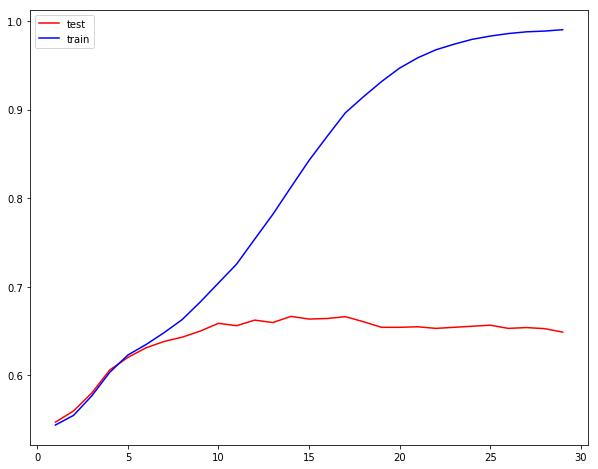

In [196]:
# Finding the best parameters

s_test = []
s_train = []
ks = np.arange(1, 30, dtype=int)
for k in ks:
  clf_ = DecisionTreeClassifier(max_depth = k)
  clf_.fit(X_train, y_train)
  s_train.append(clf_.score(X_train, y_train))
  s_test.append(clf_.score(X_test, y_test))
#clf.score(X_train, y_train), clf.score(X_test, y_test)))
s_test = np.array(s_test)
print(s_test.max(), s_test.argmax())

plt.figure(figsize=(10, 8))
plt.plot(ks, s_test, color='red', label='test')
plt.plot(ks, s_train, color='blue', label='train')
plt.legend()

## Feature importance

In [197]:
importance = clf.feature_importances_
feature_indexes_by_importance = importance.argsort()
for i in feature_indexes_by_importance:
    print('{}-{:.2f}%'.format(feature_names[i], (importance[i] *100.0)))

Vanskelig å løse ut-0.00%
Ikke gitt-0.00%
Fjernutløst-0.00%
Tørre løssnøskred-0.00%
Tørre flakskred-0.00%
Ubunden snø-0.00%
Opphopning av vann i/over lag i snødekket-0.00%
Kunstig utløst-0.00%
Nedsnødd eller nedføyket overflaterim-0.00%
mountain_weather_wind_direction_N-0.00%
mountain_weather_wind_direction_NE-0.00%
mountain_weather_wind_direction_NW-0.00%
Kantkornet snø under skarelag-0.00%
Dårlig binding mellom glatt skare og overliggende snø-0.00%
Mye vann i snøen-0.00%
Nedsnødd eller nedføyket kantkornet snø-0.00%
Kunstig utløst testheng-0.00%
Ferske skred-0.00%
Personutløst-0.00%
mountain_weather_temperature_elevation-0.00%
Også i mindre bratt terreng-0.00%
Naturlig utløst-0.00%
region_type_id-0.00%
4 - Svært store-0.00%
3 - Store-0.00%
De fleste bratte heng-0.00%
Utløst med sprengstoff-0.00%
Ukjent-0.00%
Skuterutløst-0.00%
Svært lett å løse ut-0.00%
Fersk vindtransportert snø-0.00%
Svært vanskelig å løse ut-0.00%
mountain_weather_wind_direction_None-0.01%
Drønn i snøen-0.02%
Lett

Text(0.5, 1.0, 'How much does each feature contribute?')

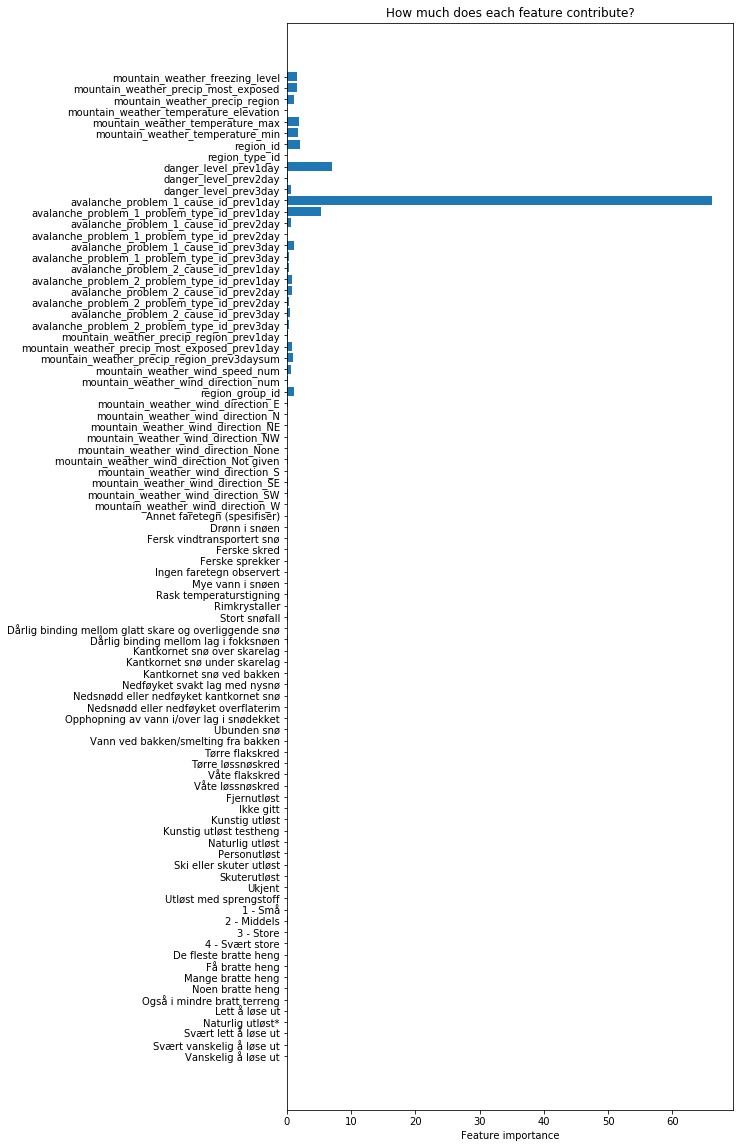

In [198]:
fig, ax = plt.subplots(figsize=(8,20))

y_pos = np.arange(len(feature_names))

ax.barh(y_pos, clf.feature_importances_*100, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(feature_names)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Feature importance')
ax.set_title('How much does each feature contribute?')

## Using RandomForest

In [199]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=30, min_samples_split=15)
rfc.fit(X_train, y_train)

predic_proba_rfc = rfc.predict_proba(X_test)
predictions_rfc = rfc.predict(X_test)
print('Random Forest Classifier with {0} leaves has a training score of {1} and a test score of {2}'.format(rf.max_depth, rf.score(X_train, y_train), rf.score(X_test, y_test)))
print(predictions_rfc)
print(predic_proba_rfc)

Random Forest Classifier with None leaves has a training score of 0.9749008864201675 and a test score of 0.9524444148671292
[7233    0 5232 ... 6232    0    0]
[[0.         0.         0.         ... 0.         0.         0.00416667]
 [1.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.00392157 0.         0.         ... 0.         0.00416667 0.00208333]
 [1.         0.         0.         ... 0.         0.         0.        ]
 [1.         0.         0.         ... 0.         0.         0.        ]]


In [200]:
rf = RandomForestRegressor(n_estimators=30, min_samples_split=15)
rf.fit(X_train, y_train)

predictions_rf = rf.predict(X_test)
print('Random Forest Regressor with {0} leaves has a training score of {1} and a test score of {2}'.format(rf.max_depth, rf.score(X_train, y_train), rf.score(X_test, y_test)))
print(predictions_rf)

Random Forest Regressor with None leaves has a training score of 0.9751723311010679 and a test score of 0.9521430915083712
[6996.51573008    0.         5373.8416164  ... 6224.86410607    0.
    0.        ]


In [201]:
importance_rf = rf.feature_importances_
feature_indexes_by_importance_rf = importance_rf.argsort()
for i in feature_indexes_by_importance_rf:
    print('{}-{:.2f}%'.format(feature_names[i], (importance_rf[i] *100.0)))

Skuterutløst-0.00%
region_type_id-0.00%
Også i mindre bratt terreng-0.00%
Kunstig utløst-0.00%
4 - Svært store-0.00%
Ukjent-0.00%
mountain_weather_wind_direction_None-0.00%
Fjernutløst-0.00%
Utløst med sprengstoff-0.00%
Kunstig utløst testheng-0.00%
mountain_weather_wind_direction_W-0.00%
mountain_weather_wind_direction_N-0.00%
De fleste bratte heng-0.00%
mountain_weather_wind_direction_E-0.00%
Kantkornet snø under skarelag-0.00%
Svært lett å løse ut-0.00%
Vann ved bakken/smelting fra bakken-0.00%
mountain_weather_wind_direction_NE-0.00%
mountain_weather_wind_direction_NW-0.01%
Nedsnødd eller nedføyket kantkornet snø-0.01%
Våte flakskred-0.01%
Tørre løssnøskred-0.01%
Ikke gitt-0.01%
mountain_weather_wind_direction_Not given-0.01%
Kantkornet snø over skarelag-0.01%
Dårlig binding mellom glatt skare og overliggende snø-0.01%
Personutløst-0.01%
Dårlig binding mellom lag i fokksnøen-0.01%
Ski eller skuter utløst-0.01%
mountain_weather_wind_direction_SE-0.01%
3 - Store-0.01%
2 - Middels-0.0

## Questions and further thoughts
- why does the RandomForestRegressor perform better than the RandomForestClassifier?
- how do I get the number of leaves of a RF?
- are there other classic ML methods that would be suitable?
- would the use of NN be beneficial? Can we use it to encode field observations?
- sometimes we know a forecast (used for training) was right or wrong, often we don't. can we flag these cases and use it as a weighting?
- use a similar feature set to get the nearest neighbor (date, region) from the forecasts in the database